In [1]:
# Set up and Installations

!pip install transformers datasets scikit-learn seaborn matplotlib pandas numpy tqdm sentencepiece
!pip install iterative-stratification
!pip install evaluate

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from tqdm import tqdm
import torch

In [4]:
#Download dataset
from datasets import load_dataset

dataset = load_dataset("lex_glue", "ecthr_b")

train_ds = dataset['train']
val_ds   = dataset['validation']
test_ds  = dataset['test']

train_df = dataset['train'].to_pandas()
val_df   = dataset['validation'].to_pandas()
test_df  = dataset['test'].to_pandas()

# full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
# full_df.to_csv("ecthr_full_dataset.csv", index=False)

train_df.head(), val_df.head(), test_df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a0e3fa4b-eb2f-4fb7-8372-da7bc8de4202)')' thrown while requesting HEAD https://huggingface.co/datasets/coastalcph/lex_glue/resolve/main/README.md
Retrying in 1s [Retry 1/5].


README.md: 0.00B [00:00, ?B/s]

ecthr_b/train-00000-of-00001.parquet:   0%|          | 0.00/42.4M [00:00<?, ?B/s]

ecthr_b/test-00000-of-00001.parquet:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

ecthr_b/validation-00000-of-00001.parque(…):   0%|          | 0.00/5.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

(                                                text     labels
 0  [11.  At the beginning of the events relevant ...        [4]
 1  [9.  The applicant is the monarch of Liechtens...  [8, 3, 9]
 2  [9.  In June 1949 plots of agricultural land o...        [3]
 3  [8.  In 1991 Mr Dušan Slobodník, a research wo...  [6, 8, 5]
 4  [9.  The applicant is an Italian citizen, born...     [8, 3],
                                                 text        labels
 0  [5.  The applicant was born in 1983 and is det...           [4]
 1  [5.  The applicant was born in 1982 and is cur...           [1]
 2  [5.  The applicant was born in 1955 and lives ...        [1, 3]
 3  [6.  The applicant was born in 1977 and lives ...            []
 4  [6.  The applicants were born in 1983 and 2007...  [7, 2, 3, 4],
                                                 text  labels
 0  [5.  The applicant is a journalist for DN.no, ...     [6]
 1  [5.  The applicant was born in 1940 and lives ...     [4]
 2  [5.  The a

In [5]:
# Dataset features
dataset['train'].features['labels']

List(ClassLabel(names=['2', '3', '5', '6', '8', '9', '10', '11', '14', 'P1-1']))

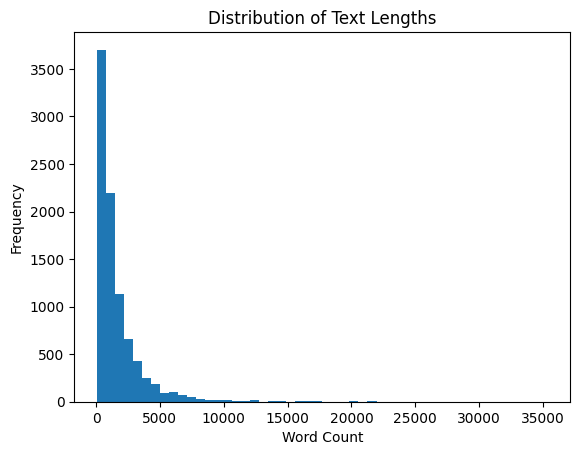

In [6]:
# Text length distribution
train_text_lengths = [
    len(str(text).split())
    for text in train_ds["text"]
]

plt.hist(train_text_lengths, bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

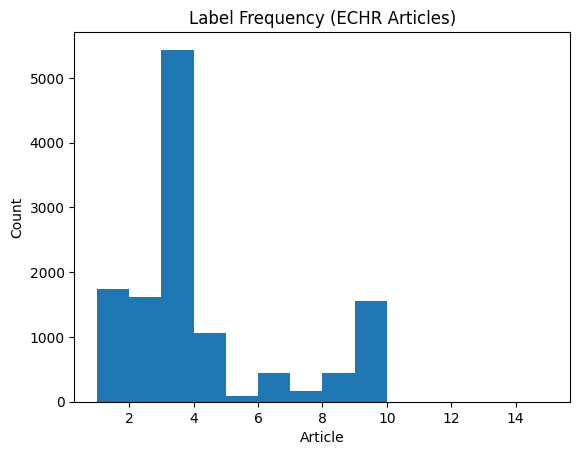

In [7]:
# Label frequency
all_labels = [label for case in train_ds['labels'] for label in case]
plt.hist(all_labels, bins=range(1, 16))
plt.title("Label Frequency (ECHR Articles)")
plt.xlabel("Article")
plt.ylabel("Count")
plt.show()

In [8]:
# Data Preprocessing
import re

def clean_text(text):
    if isinstance(text, list):
        text = " ".join(text)
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text

train_ds = train_ds.map(lambda x: {"text": clean_text(x['text'])})
val_ds   = val_ds.map(lambda x: {"text": clean_text(x['text'])})
test_ds  = test_ds.map(lambda x: {"text": clean_text(x['text'])})

train_df = train_ds.to_pandas()
train_df.dropna(subset=['text'], inplace=True)
train_df.drop_duplicates(subset=['text'], inplace=True)
len(train_df)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

8999

In [9]:
# Tokenization
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [10]:
# Prepare Multi-Label Targets
mlb = MultiLabelBinarizer()
mlb.fit(dataset['train']['labels'])

from datasets import ClassLabel, Value

num_labels = len(mlb.classes_)

def encode_labels(example):
    # Return a list of float32, not torch tensor
    example["labels"] = mlb.transform([example["labels"]])[0].astype(np.float32).tolist()
    return example

# Apply to all datasets
train_tok = train_tok.map(encode_labels)
val_tok   = val_tok.map(encode_labels)
test_tok  = test_tok.map(encode_labels)

# Now set format to torch
train_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
val_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])
test_tok.set_format(type="torch", columns=["input_ids","attention_mask","labels"])

# Sanity check
print(train_tok[0]["labels"].dtype)  # should now be torch.float32
print(train_tok[0]["labels"])        # check values

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

torch.int64
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])


In [11]:
set([example["labels"].shape[0] for example in train_tok])


{10}

In [12]:
# Baseline Model (No Fine-Tuning)
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# Fine-Tuned Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Hyperparameter Tuning Setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,           # log train loss every 50 steps
    logging_first_step=True,
    load_best_model_at_end=True,
    report_to="none",
    fp16=True,
)

# Compute Metrics
import evaluate
from sklearn.metrics import f1_score

# metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).cpu().numpy()
    labels = labels.astype(int)   # convert float labels → int
    return {
        "f1_micro": f1_score(labels, preds, average="micro"),
        "f1_macro": f1_score(labels, preds, average="macro")
    }


from transformers import default_data_collator

def collate_fn(batch):
    batch = default_data_collator(batch)
    batch['labels'] = batch['labels'].float()
    return batch

model.to("cuda")

# Train Fine-Tuned Model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

trainer.train()


PyTorch: setting up devices
Using auto half precision backend
The following columns in the Training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9,000
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 5,640
  Number of trainable parameters = 109,489,930


Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro
1,0.155500,0.183805,0.730258,0.616703
2,0.132400,0.192387,0.709141,0.610314
3,0.117200,0.182261,0.733676,0.616032
4,0.098800,0.186870,0.751052,0.647581
5,0.081000,0.193749,0.738636,0.646905
6,0.066800,0.197290,0.748097,0.642001
7,0.062600,0.200541,0.755323,0.662802
8,0.052100,0.212260,0.748212,0.705553
9,0.041900,0.224672,0.747601,0.686162


The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-282
Configuration saved in ./results/checkpoint-282/config.json
Model weights saved in ./results/checkpoint-282/model.safetensors
The following columns in the Evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32
Saving model checkpoint to ./results/checkpoint-564
Configuration saved in ./results/checkpoint-564/config.json
Model weights saved in ./results/checkpoint-564/mo

KeyboardInterrupt: 

In [28]:
# Evaluate Baseline vs Fine-Tuned
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
import torch
from transformers import default_data_collator

def eval_collate_fn(batch):
    batch = default_data_collator(batch)
    batch["labels"] = batch["labels"].float()
    return batch

def evaluate_model(model, ds, batch_size=32):
    model.eval()

    eval_loader = DataLoader(
        ds,
        batch_size=batch_size,
        collate_fn=eval_collate_fn
    )

    all_preds = []
    all_labels = []

    for batch in eval_loader:
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)
        labels = batch["labels"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        preds = (torch.sigmoid(logits) > 0.5).cpu()
        all_preds.append(preds)
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    return f1_score(all_labels, all_preds, average="micro")

baseline_model.to("cuda")
model.to("cuda")

baseline_score = evaluate_model(baseline_model, test_tok)
fine_tuned_score = evaluate_model(model, test_tok)

baseline_score, fine_tuned_score


(0.21851590106007068, 0.7320782041998551)

In [31]:
# Predict on Test Set
def predict_collate_fn(batch):
    batch = default_data_collator(batch)  # handles input_ids, attention_mask, etc.
    if 'labels' in batch:
        # Ensure float32 labels if present (optional for test set)
        batch['labels'] = batch['labels'].float()
    return batch

# Create a DataLoader for test set
test_loader = DataLoader(test_tok, batch_size=8, collate_fn=predict_collate_fn)

all_preds = []

for batch in test_loader:
    input_ids = batch['input_ids'].to(model.device)
    attention_mask = batch['attention_mask'].to(model.device)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

    # Convert logits to 0/1 predictions
    preds = (torch.sigmoid(logits) > 0.5).int().cpu()
    all_preds.append(preds)

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0).numpy()

# Decode multi-label predictions
decoded_preds = mlb.inverse_transform(all_preds)
decoded_preds_cleaned = [
    [int(label) for label in t] if t else []  # convert np.int64 → int, empty tuple → empty list
    for t in decoded_preds
]

# print(decoded_preds_cleaned)
test_df["predicted_labels"] = decoded_preds_cleaned
test_df

,text,labels,predicted_labels
0,"[5. The applicant is a journalist for DN.no, ...",[6],[6]
1,[5. The applicant was born in 1940 and lives ...,[4],"[3, 4]"
2,[5. The applicant was born in 1965 and lives ...,[3],[3]
3,[5. The applicant was born in 1967 and lives ...,[3],[3]
4,[5. The applicant was born in 1967 and lives ...,"[1, 3]",[1]
...,...,...,...
995,[5. The applicants were born in 1971 and 1976...,"[6, 3]",[3]
996,"[5. The applicant, who was born in 1948, live...","[6, 1, 2, 3]","[1, 2]"
997,[5. The applicant was born in 1980 and lives ...,[3],"[1, 2, 3]"
998,[4. The applicant was born in 1972 and is det...,[1],"[1, 3]"
